Dec 9, 2024
shift to v1.1.0

run on any data from this DRP

This code needs the shadow height code, since the values in the headers are still not correct, and the solar spectrum for correcting for moon contamination

In [4]:
# load packages
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits, ascii
import urllib.request
import io

from astropy.wcs import wcs
from astropy.table import Table
import math 

from scipy.ndimage import median_filter
from astropy.modeling import models, fitting


from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
from astropy.time import Time

from shadow_height_lib import shadow_calc

import matplotlib as mpl
import pickle

from astropy.table import QTable
from astropy import table

import glob
import os
import datetime 
import scipy 

import astral
from astropy.time import Time, TimezoneInfo
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astral.sun import sun
from datetime import date, time, timezone


In [2]:
font = {'size'   : 18}

mpl.rc('font', **font)

In [5]:
def load_file_EW(t):
    rsshdu = fits.open(t)
    rsshdu.info

    hdr = rsshdu['PRIMARY'].header

    wave=rsshdu['WAVE'].data 

    r1 = rsshdu['FLUX'].data
    r1_ivar = rsshdu['IVAR'].data
    mask = rsshdu['MASK'].data
    sky = rsshdu['SKY'].data
    tab = Table(rsshdu['SLITMAP'].data)
#    print(tab)

    r1[mask == 1] = np.nan

    skyW = (tab['targettype'] == 'SKY') & (tab['telescope']=='SkyW') & (tab['fibstatus']==0)
    skyE = (tab['targettype'] == 'SKY') & (tab['telescope']=='SkyE') & (tab['fibstatus']==0)
    sci  = (tab['targettype'] == 'SCI') & (tab['fibstatus']==0)

    east_sky_spec = np.nanmedian(r1[skyE,:]+sky[skyE,:],axis=0)
    west_sky_spec = np.nanmedian(r1[skyW,:]+sky[skyW,:],axis=0)

    east_sky_spec_ivar = np.nanmedian(r1_ivar[skyE,:],axis=0)
    west_sky_spec_ivar = np.nanmedian(r1_ivar[skyW,:],axis=0)    
    
    rsshdu.close()

    return wave, west_sky_spec, east_sky_spec, west_sky_spec_ivar, east_sky_spec_ivar, hdr
    

In [6]:
def kin_fit(wave,r1,r1_ivar,line=6563):
    if line==6533:
        wl_ha = (wave > 6530) & (wave < 6540)
        mm = 6533
#        print('6533 line')
    if line==6554:
        wl_ha = (wave > 6550) & (wave < 6560)
        mm = 6554
#        print('6554 line')
    if line == 6563:
        mm = 6562.79
        wl_ha = (wave > 6559) & (wave < 6566)

    iis_ha = np.where(wl_ha)[0]
    an_amplitude = r1[iis_ha].max()
    an_mean = mm
#    an_stddev = np.sqrt(np.sum((wave[iis_ha] - an_mean)**2) / (len(wave[iis_ha]) - 1))
#    an_stddev = 2.
    an_stddev = 0.65
    g_init = models.Gaussian1D(amplitude=an_amplitude, mean=an_mean, stddev=an_stddev)+models.Const1D(0)

    #how much do we trust the wavelength solution?
    if False:
        g_init.mean_0.fixed = True
#    g_init.stddev_0.fixed = True

    fit_g = fitting.LevMarLSQFitter()

    g = fit_g(g_init, wave[iis_ha], r1[iis_ha], weights=r1_ivar[iis_ha])#, weights=1.0/r1_err[iis_ha])
#    print(g)

    fib_area = np.pi*(LVM_FIBER_DIAMETER/2.)**2

    flux = g.amplitude_0.value * np.sqrt(2.*np.pi*g.stddev_0.value**2)/fib_area #erg/s/cm^2/arcsec^2
    mean = g.mean_0.value
    stddev = g.stddev_0.value
#    vel = np.append(vel, 3e5 * (means - 6562.81)/6562.81)
 
    #print(g_init.param_names)
    try:
        cov_diag = np.diag(fit_g.fit_info['param_cov'])
        flux_err = (g.amplitude_0.value + np.sqrt(cov_diag[0])) * np.sqrt(2.*np.pi*g.stddev_0.value**2)/fib_area - flux
    except:
#        print(f"covariances didn't work, line: {line}, flux: {flux}")
        flux_err = np.nan
        

    return flux, mean, stddev, g(wave), flux_err


In [7]:
def forward(x):
    return x / 5.661e-18 # returns Rayleigh

def inverse(x):
    return x * 5.661e-18 # returns erg/s/cm^2/arcsec^2

In [8]:
# load in the WHAM darkest field list
#wham = Table.read('darkest_WHAM_list.csv',format='csv')
#cc_wham = SkyCoord(wham['ra[deg]'],wham['dec[deg]'],frame='icrs',unit=u.deg)

# initialize the shadow height calculation
s=shadow_calc()

# read in the solar spectrum
# from: https://www.eso.org/observing/dfo/quality/GIRAFFE/pipeline/solar.html
cwd = os.getcwd()
solarhdu = fits.open(cwd+'/solar_spectra/r.UVES.2004-09-26T22:19:08.058_0007.fits')
solarspec = solarhdu[0].data
solarhdr = solarhdu[0].header
solarhdu.close()

solarwl = np.arange(solarhdr['NAXIS1'])*solarhdr['CDELT1'] + solarhdr['CRVAL1']
solarspec_avg = np.mean(solarspec, axis=0)

# fudge the kernel size? R~4000 vs 0.1A sampling -> factor of 17
solarspec_avg2 = scipy.signal.medfilt(solarspec_avg, kernel_size=17*5)


In [9]:
# https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
# https://www.spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt
# Daily flux values are the radio emission from the Sun at a wavelength of 10.7 centimetres recorded daily.
# https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-3-en.php
#sun = table.Table.read('solar_fluxtable.txt', format='ascii')  

# switch the sun data to read directly from the webpage:
# https://www.spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt

# URL of the text file
url = 'https://www.spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt'  # Replace with the actual URL of the file

# Fetch the file from the URL
response = urllib.request.urlopen(url)
data = response.read().decode('utf-8')  # Decode the byte response to a string


# Read the data into an Astropy Table
# Assuming the file is space-separated; change 'format' accordingly (e.g., 'csv', 'ascii.tab')
sun = Table.read(data, format='ascii.basic', delimiter=' ', guess=False, fast_reader=False,comment='-')


In [31]:
# point this at wherever you want to do the geocoronal fits

#test_data2 = glob.glob(DIR_redux+'Orion/orion/*.fits')

test_data = glob.glob(DIR_redux+'**/lvmSFrame*.fits', recursive=True)

print(len(test_data))
#test_data = test_data[0:200]

drpall = table.Table.read(DIR_redux+'drpall-'+ver+'.fits')


1807


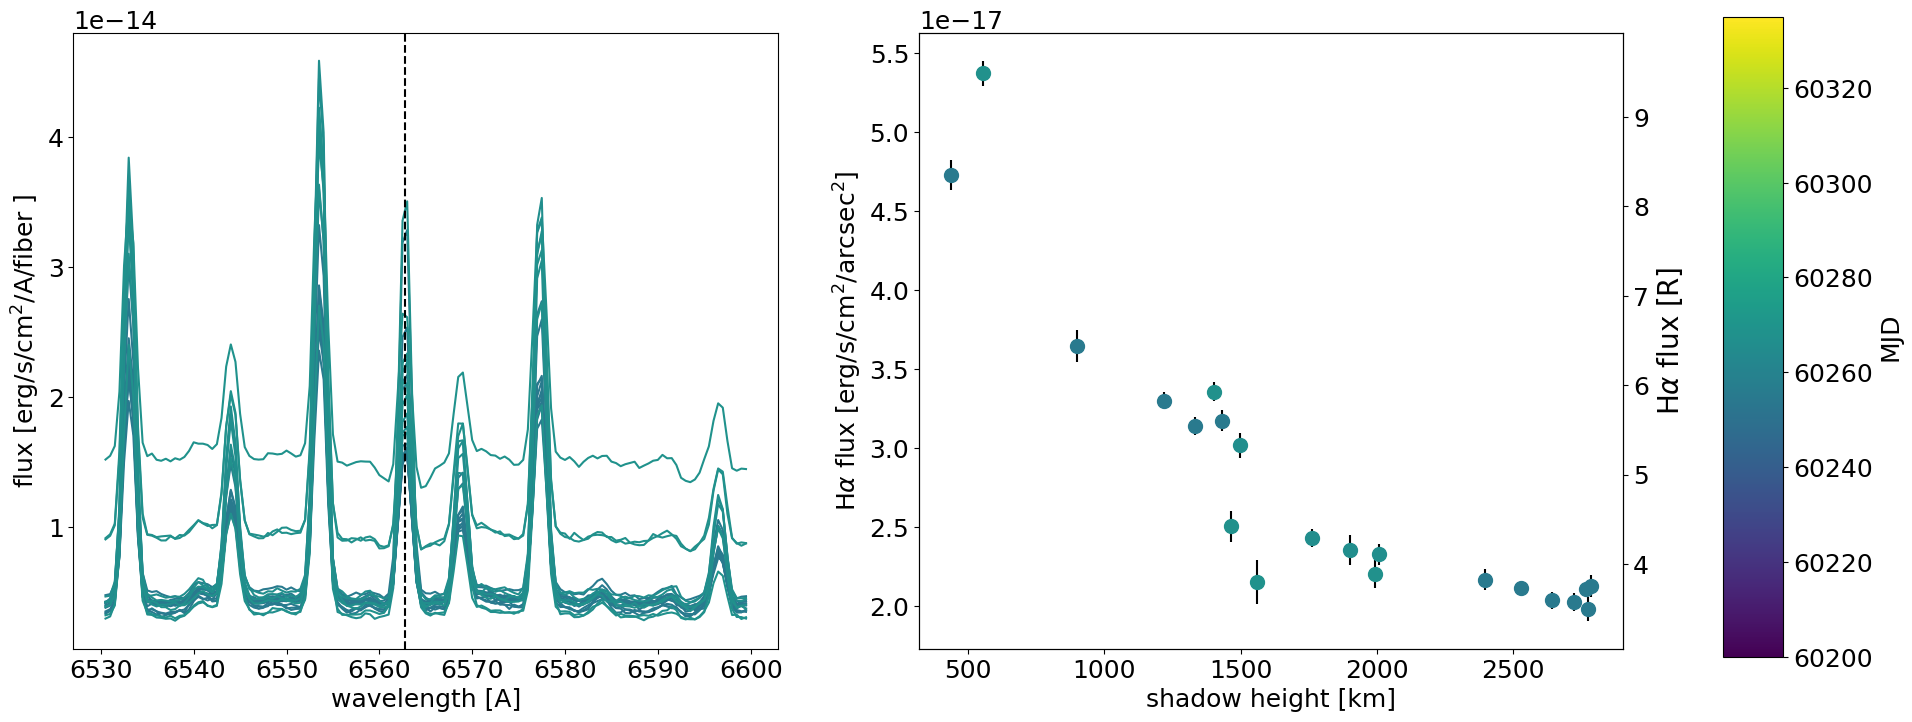

In [32]:
# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

#fig = plt.figure(figsize=(20,10))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

d = {}

for t in test_data:
    ii=t.find('sdsswork')
    dd = drpall[t[ii:] == drpall['location']]
    
    if (dd['skye_name'][0][0:4] == 'WHAM'):
        which_sky = 'SKYE'
        wham_name = dd['skye_name']
    elif (dd['skyw_name'][0][0:4] == 'WHAM'):
        which_sky = 'SKYW'
        wham_name = dd['skyw_name']
    else:
        which_sky = 'None'
        
    if (dd['exptime'] != 900) | (which_sky == 'None'): 
        # don't bother with the short exposures or fields without WHAM sky
        continue

    wave, swm, sem, swm_ivar, sem_ivar, hdr = load_file_EW(t)

    mjd = hdr['MJD']
    frame = hdr['EXPOSURE']

    if (which_sky == 'SKYE'):
        # find the WHAM field
        sm = sem
        sm_ivar = sem_ivar
        cc =  SkyCoord(dd['skye_ra'],dd['skye_dec'],frame='icrs',unit=u.deg)

    elif (which_sky == 'SKYW'):
        sm = swm
        sm_ivar = swm_ivar
        cc =  SkyCoord(dd['skyw_ra'],dd['skyw_dec'],frame='icrs',unit=u.deg)


    # check there are enough standards observed
    ctr_stds=0
    for std in np.arange(1,13): 
        if hdr[f'STD{std:.0f}ACQ']:
            ctr_stds+=1
    if ctr_stds < 11:
        continue

    # take only survey tiles
    if (hdr['TILE_ID'] == 11111):
        continue
            

    sub=(wave > 6530) & (wave < 6600)

    # test if EW is too high
    iis_ha = (wave > 6561) & (wave < 6565)

    # test if baseline is bad
    baseline = np.median(sm[sub])
    if (baseline < 0) | (baseline > 4e-14) | (np.median(sm[(wave > 6530) & (wave < 6540)]) < 0):
        continue


    if (np.sum(sm[iis_ha]) > np.median(sm[sub])*np.sum(iis_ha)) & (np.median(sm[sub]) > 0) :
        time = Time(hdr['OBSTIME'],format='isot', scale='utc')
        jj = time.jd
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        hz = s.get_heights(return_heights=True, unit="km")
        hz_hdr = hdr['HIERARCH GEOCORONAL '+which_sky+'_SH_HGHT']
        #hz = hz_hdr #these values seem to still be wrong

        am = hdr['TE'+which_sky+'AM']
        rho = hdr['HIERARCH SKYMODEL '+which_sky+'_RHO']
        alpha = hdr['HIERARCH SKYMODEL ALPHA']
        altmoon = hdr['HIERARCH SKYMODEL MOONALT']
        sunalt = hdr['HIERARCH SKYMODEL SUNALT']
#        s_alt = astral.sun.elevation(observer,dateandtime=obs_time)
        s_alt = sunalt

        obs_time = datetime.datetime.fromisoformat(hdr['OBSTIME']) #time #in UTC

        loc = EarthLocation.of_site('Las Campanas Observatory')
        observer = astral.Observer(latitude=loc.lat.deg, longitude=loc.lon.deg, elevation=loc.height.value)


        # interpolate the solar spectrum onto the wavelength grid of the RSS
#        f = interp1d(solarwl, solarspec_avg2, kind='cubic')
#        solarspec_avg_interp = f(wave[sub])
        solarspec_avg_interp = np.interp(wave[sub], solarwl, solarspec_avg2)

#        iis_cont = ((wave[sub] > 6535) & (wave[sub] < 6542)) | ((wave[sub]>6555) & (wave[sub] < 6561)) | ((wave[sub]>6565)&(wave[sub]<6567)) | ((wave[sub]>6580)&(wave[sub] <6590))
        iis_cont = ((wave[sub]>6555) & (wave[sub] < 6561)) | ((wave[sub]>6565)&(wave[sub]<6567)) 

        scl = np.median(sm[sub][iis_cont]/solarspec_avg_interp[iis_cont])

        # fit the spectrum
        if ((altmoon > 0) & (np.abs(alpha-180) < 20)): #  | ((np.abs(alpha-180) < 50) & (altmoon > 0) & (rho < 40)):
            flux6533, mean6533, stddev, fit0, flux6533e = kin_fit(wave[sub],sm[sub],sm_ivar[sub],line=6533)
            flux6554, mean6554, stddev, fit0, flux6554e = kin_fit(wave[sub],sm[sub],sm_ivar[sub],line=6554)
            flux, mean, stddev, fit, flux_err = kin_fit(wave[sub],sm[sub]-solarspec_avg_interp*scl, sm_ivar[sub])
            fit = fit+solarspec_avg_interp*scl
        else:
            flux6533, mean6533, stddev, fit0,flux6533_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub], line=6533)
            flux6554, mean6554, stddev, fit0,flux6554_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub], line=6554)
            flux, mean, stddev, fit, flux_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub])

        waveS = wave[sub]
        specS = sm[sub]
        fitS = fit

        iis = np.argmin(np.abs(time.jd - sun['fluxjulian']))
        solar_obsflux = sun['fluxobsflux'][iis]

        axes[0].plot(wave[sub], sm[sub],color=s_map.to_rgba(mjd))
#        axes[0].plot(wave[sub], sm[sub]*np.sqrt(sm_ivar[sub]),color=s_map.to_rgba(mjd)) #S/N
        axes[1].scatter(hz,flux,s=100,color=s_map.to_rgba(mjd),label=mjd)        
        axes[1].errorbar(hz,flux,yerr = flux_err,zorder=0,ecolor='k')

        d[frame] = {'MJD':mjd, 'WHAM':wham_name, 
                    'center':mean, 
                    'flux':flux, 
                    'flux_err':flux_err, 
                    'stddev': stddev,
                    'am':am,
                    'hz':hz,
                    'filename':t,
                    'sky':which_sky,
                    'baseline':baseline,
                    'rho':rho,
                    'center6533':mean6533,
                    'flux6533':flux6533,
                    'center6554':mean6554,
                    'flux6554':flux6554,
                    'sun_alt':s_alt,
                    'time':time,
                    'solar_obsflux': solar_obsflux,
                    'wave':waveS,
                    'spec':specS,
                    'fit':fitS}

    
#plt.colorbar(s_map, label=r'MJD')

# add color bars
cbaxes = fig.add_axes([0.95, 0.10, 0.03, 0.8]) 
cb = plt.colorbar(s_map,cax = cbaxes,orientation='vertical')#,ticks=[0,1.0,2.0,3.0,4.0]) 
cb.set_label('MJD')

axes[0].axvline(6562.79,color='k',linestyle='dashed')


axes[0].set_xlabel('wavelength [A]')
axes[0].set_ylabel(r'flux [erg/s/cm$^2$/A/fiber ]')

axes[1].set_xlabel('shadow height [km]')
axes[1].set_ylabel(r'H$\alpha$ flux [erg/s/cm$^2$/arcsec$^2$]')

ax2 = axes[1].twinx()
lim1,lim2 = axes[1].get_ylim()
ax2.set_ylim(forward(lim1),forward(lim2))
ax2.set_ylabel(r'H$\alpha$ flux [R]',size=20)

with open('v'+ver+'_saved_dictionary_geocoronal.pkl', 'wb') as f:
    pickle.dump(d, f)

fig.savefig('v'+ver+'_geocoronal_compiled_all.png')

In [ ]:
with open('v'+ver+'_saved_dictionary_geocoronal.pkl', 'rb') as f:
    d = pickle.load(f)

c_frame = []
c_mjd = []
c_wham = []
c_center = []
c_flux = []
c_flux_err = []
c_stddev = []
c_center6533 = []
c_flux6533 = []
c_center6554 = []
c_flux6554 = []
c_am = []
c_hz = []
c_filename = []
c_sky = [] 
c_baseline = []
c_rho = []
c_salt = []
c_time = []
c_solar_obsflux = []

for dd in d:
    c_frame.append(dd)
    c_mjd.append(d[dd]['MJD'])
    c_wham.append(d[dd]['WHAM'])
    c_center.append(d[dd]['center'])
    c_flux.append(d[dd]['flux'])
    c_flux_err.append(d[dd]['flux_err'])
    c_stddev.append(d[dd]['stddev'])
    c_center6533.append(d[dd]['center6533'])
    c_flux6533.append(d[dd]['flux6533'])
    c_center6554.append(d[dd]['center6554'])
    c_flux6554.append(d[dd]['flux6554'])
    c_am.append(d[dd]['am'])
    c_hz.append(d[dd]['hz'])
    c_filename.append(d[dd]['filename'])
    c_sky.append(d[dd]['sky'])
    c_baseline.append(d[dd]['baseline'])
    c_rho.append(d[dd]['rho'])
    c_salt.append(d[dd]['sun_alt'])
    c_time.append(d[dd]['time'])
    c_solar_obsflux.append(d[dd]['solar_obsflux'])
#d[frame] = {'MJD':mjd, 'WHAM':wham['name'][cc_w.separation(cc_wham).deg < 1][0], 'center':meanw, 'flux':fluxw, 'am':amw,'hz':hzw}

t = QTable([c_frame, c_mjd, c_wham, c_center, c_flux, c_flux_err, c_stddev, c_center6533,c_flux6533, c_center6554,c_flux6554, c_am, c_hz, c_filename, c_sky,c_baseline,c_rho,c_salt,c_time, c_solar_obsflux],
           names=('frame', 'mjd', 'wham', 'center','flux','flux_err','stddev','center6533','flux6533','center6554','flux6554','am','hz','filename', 'sky','baseline','rho','sun_alt','time','solar_obsflux'),
           meta={'name': 'first table'})

t.write('v'+ver+'_saved_dictionary_geocoronal.fits', overwrite=True)  

make plots for a specific night

Text(6554, 3.994075466425843e-14, 'OH')

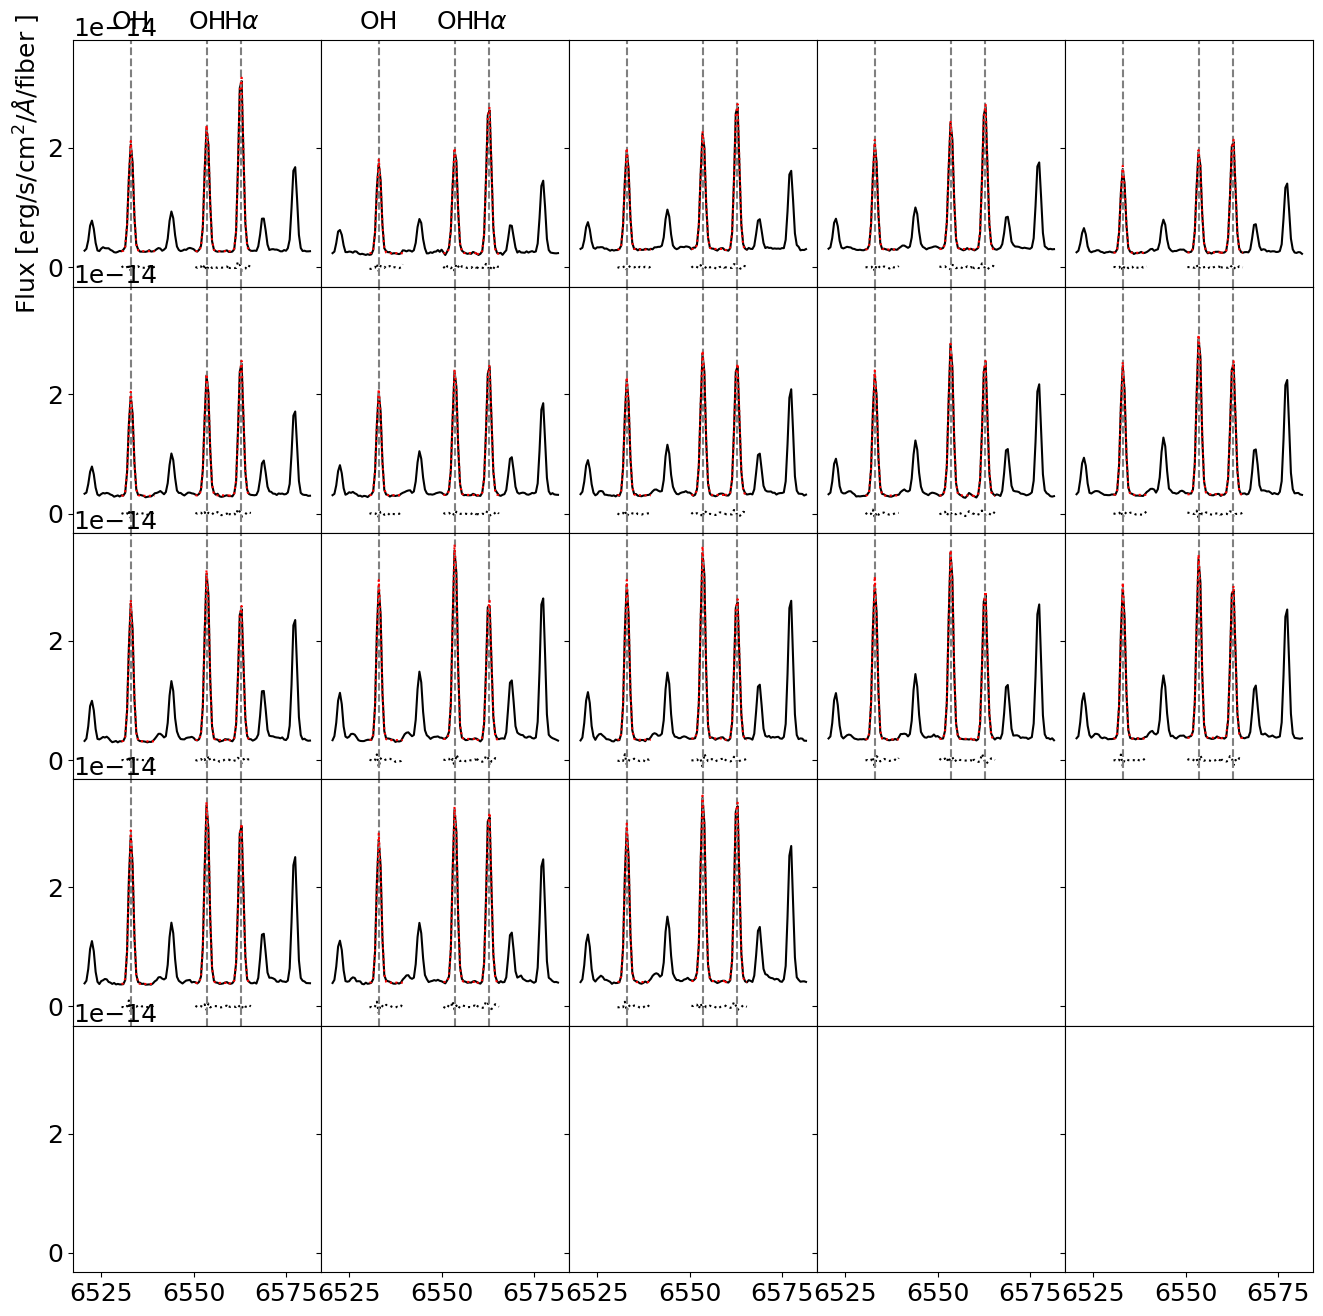

In [57]:
# sample fit plot
def plotty(axes, wave, sm, sub):     
    # interpolate the solar spectrum onto the wavelength grid of the RSS
    #        f = interp1d(solarwl, solarspec_avg2, kind='cubic')
    #        solarspec_avg_interp = f(wave[sub])
    solarspec_avg_interp = np.interp(wave[sub], solarwl, solarspec_avg2)

    #        iis_cont = ((wave[sub] > 6535) & (wave[sub] < 6542)) | ((wave[sub]>6555) & (wave[sub] < 6561)) | ((wave[sub]>6565)&(wave[sub]<6567)) | ((wave[sub]>6580)&(wave[sub] <6590))
    iis_cont = ((wave[sub]>6555) & (wave[sub] < 6561)) | ((wave[sub]>6565)&(wave[sub]<6567)) 

    scl = np.median(sm[sub][iis_cont]/solarspec_avg_interp[iis_cont])
    
    # fit the spectrum
    if ((altmoon > 0) & (np.abs(alpha-180) < 20)): #  | ((np.abs(alpha-180) < 50) & (altmoon > 0) & (rho < 40)):
        flux6533, mean6533, stddev, fit6533, flux6533e = kin_fit(wave[sub],sm[sub],sm_ivar[sub],line=6533)
        flux6554, mean6554, stddev, fit6554, flux6554e = kin_fit(wave[sub],sm[sub],sm_ivar[sub],line=6554)
        flux, mean, stddev, fit, flux_err = kin_fit(wave[sub],sm[sub]-solarspec_avg_interp*scl, sm_ivar[sub])
        fit = fit+solarspec_avg_interp*scl
    else:
        flux6533, mean6533, stddev, fit6533,flux6533_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub], line=6533)
        flux6554, mean6554, stddev, fit6554,flux6554_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub], line=6554)
        flux, mean, stddev, fit, flux_err = kin_fit(wave[sub],sm[sub],sm_ivar[sub])

    wl_6533 = (wave[sub] > 6530) & (wave[sub] < 6540)
    wl_6554 = (wave[sub] > 6550) & (wave[sub] < 6560)
    wl_ha = (wave[sub] > 6559) & (wave[sub] < 6566)

    axes.plot(wave[sub], sm[sub],color='k')
    axes.plot(wave[sub][wl_6533],fit6533[wl_6533],color='r',linestyle='dotted',zorder=10)
    axes.plot(wave[sub][wl_6554],fit6554[wl_6554],color='r',linestyle='dotted',zorder=10)
    axes.plot(wave[sub][wl_ha],fit[wl_ha],color='r',linestyle='dotted',zorder=10)

    axes.plot(wave[sub][wl_6533],sm[sub][wl_6533]-fit6533[wl_6533],color='k',linestyle='dotted')
    axes.plot(wave[sub][wl_6554],sm[sub][wl_6554]-fit6554[wl_6554],color='k',linestyle='dotted')
    axes.plot(wave[sub][wl_ha],sm[sub][wl_ha]-fit[wl_ha],color='k',linestyle='dotted')



    axes.axvline(mean,color='grey',linestyle='dashed')
    axes.axvline(mean6533,color='grey',linestyle='dashed')
    axes.axvline(mean6554,color='grey',linestyle='dashed')
    
    return flux


## Pick a specific MJD to plot
iis = (drpall['mjd'] == 60322) & (drpall['exptime']==900) 

tt = drpall['location'][iis].data

fig, axsG = plt.subplots(nrows=math.ceil(len(tt)/5), ncols=5, figsize=(16, 16),sharey=True,sharex = True,gridspec_kw={'wspace':0,'hspace':0})
axs = axsG.flatten()

ctr = 0
for t in tt:
#    ii=t.find('sdsswork')
    dd = drpall[t == drpall['location']]
    
    t_loc = DIR_redux[0:DIR_redux.find('sdsswork')]+t.decode('utf-8')

    if (os.path.exists(t_loc) is False) | (dd['exptime'] != 900):
        # don't bother with the short exposures or fields without WHAM sky
        continue
    
    wave, swm, sem, swm_ivar, sem_ivar, hdr = load_file_EW(t_loc)

    mjd = hdr['MJD']
    frame = hdr['EXPOSURE']

    if (dd['skye_name'][0][0:4] == 'WHAM'):
        which_sky = 'SKYE'
        wham_name = dd['skye_name']
        sm = sem
        sm_ivar = sem_ivar
        cc =  SkyCoord(dd['skye_ra'],dd['skye_dec'],frame='icrs',unit=u.deg)
    elif (dd['skyw_name'][0][0:4] == 'WHAM'):
        which_sky = 'SKYW'
        wham_name = dd['skyw_name']
        sm = swm
        sm_ivar = swm_ivar
        cc =  SkyCoord(dd['skyw_ra'],dd['skyw_dec'],frame='icrs',unit=u.deg)
    else:
        continue    
        
        
    sub=(wave > 6520) & (wave < 6582)

    flux = plotty(axs[ctr],wave,sm, sub)
    ctr+=1
    

axs[0].set_xlabel(r'Wavelength [$\AA$]')
axs[1].set_xlabel(r'Wavelength [$\AA$]')
axs[0].set_ylabel(r'Flux [erg/s/cm$^2$/$\AA$/fiber ]')

ylims = axs[0].get_ylim()

axs[0].text(6563,ylims[1]*1.05,r'H$\alpha$', ha='center')
axs[0].text(6533,ylims[1]*1.05,r'OH', ha='center')
axs[0].text(6554,ylims[1]*1.05,r'OH', ha='center')

axs[1].text(6563,ylims[1]*1.05,r'H$\alpha$', ha='center')
axs[1].text(6533,ylims[1]*1.05,r'OH', ha='center')
axs[1].text(6554,ylims[1]*1.05,r'OH', ha='center')


#fig.savefig('v'+ver+'_geocoronal_example_spec_fit.png')
